# Kinoshita Curve River Transect Example

This notebook showcases an example of the _WigglyRivers_ tool by creating, extracting, and interpreting the meandering features of Kinoshita-type river transects. The Kinoshita curve can be estimated using the the function `RiverFunctions.kinoshita_curve_zolezzi(...)`. This equation uses the equations of the Kinoshita curve provided by Zolezzi and Güneralp (2016). The Kinoshita curve uses the following equations to calculate the direction angle ($\theta$) and the curvature ($C$).

$$\theta = \theta_0 \cos(\kappa s) + \theta_{s} \sin(3\kappa s) + \theta_f \cos(3\kappa s)$$

$$C=\kappa[\theta_0 \sin(\kappa s) - 3\theta_s\cos(3\kappa s) + 3\theta_f\sin(3\kappa s)]$$

where $\kappa=2\pi/\lambda$, $\lambda$ is the wavelength of the meander, $\theta_0$ is the amplitude of the direction angle oscillation, and $\theta_s$ and $\theta_f$ are the skewness and fatness coefficients, respectivelly.

## Workflow

To start with this workflow we first import the packages necessary to run the code.

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib ipympl

In [2]:
# Importing Packages
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from IPython.display import Image, display, HTML
from IPython.display import display
from scipy.signal import find_peaks


# Importing WigglyRivers Packages
from WigglyRivers import RiverDatasets
from WigglyRivers import RiverFunctions as RF
from WigglyRivers.utilities import utilities as utl
from WigglyRivers.utilities import filesManagement as FM
from WigglyRivers import Logger
from WigglyRivers import graphs

# Set seed for numpy
np.random.seed(0)

In [3]:
# Start Logger to keep track of the code, not needed to run the codes
logger = Logger(console=True)

2024-02-05 12:35:04,673[INFO] set_logger: Starting log


### Creation of the Kinoshita-type River Transect

The following code block shows how to create a river transect using a Kinoshita curve. 

2024-02-05 21:12:17,600[INFO] info: Start Logger in RiverDatasets


/Users/dgd042/Documents/work/myRepos/inDevelopment/WigglyRivers/WigglyRivers/rivers/RiverFunctions.py:824: RuntimeWarning: All-NaN slice encountered
  w_value = np.nanmin(w)
2024-02-05 21:12:17,670[INFO] info:   Running CWT...
2024-02-05 21:12:17,737[INFO] info:   Getting the scale tree...
2024-02-05 21:12:18,482[INFO] info:   Finding peaks in CWT...
2024-02-05 21:12:18,567[INFO] info:   Detecting meanders...
2024-02-05 21:12:18,575[INFO] info:   Projecting tree in planimetry...


R_hm 17.147732725454787
lambda 199.59673893556737
lambda_hm 100.00000924546553
lambda_fm 200.05715919293831


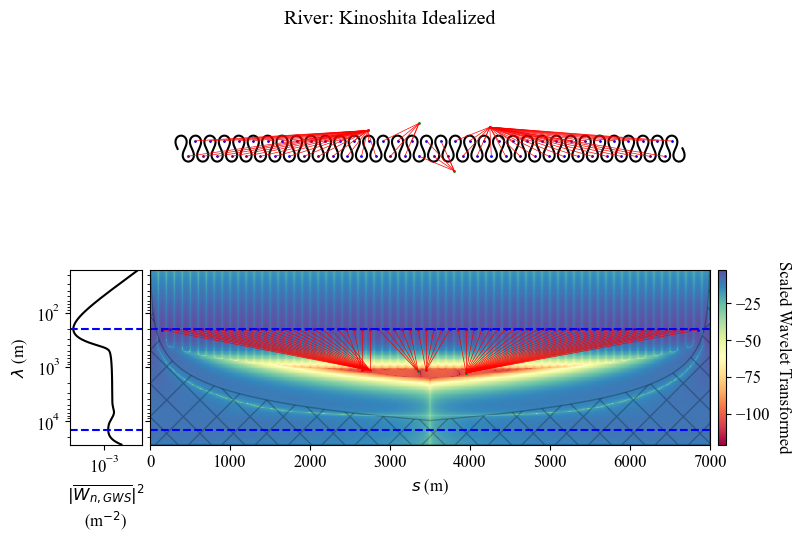

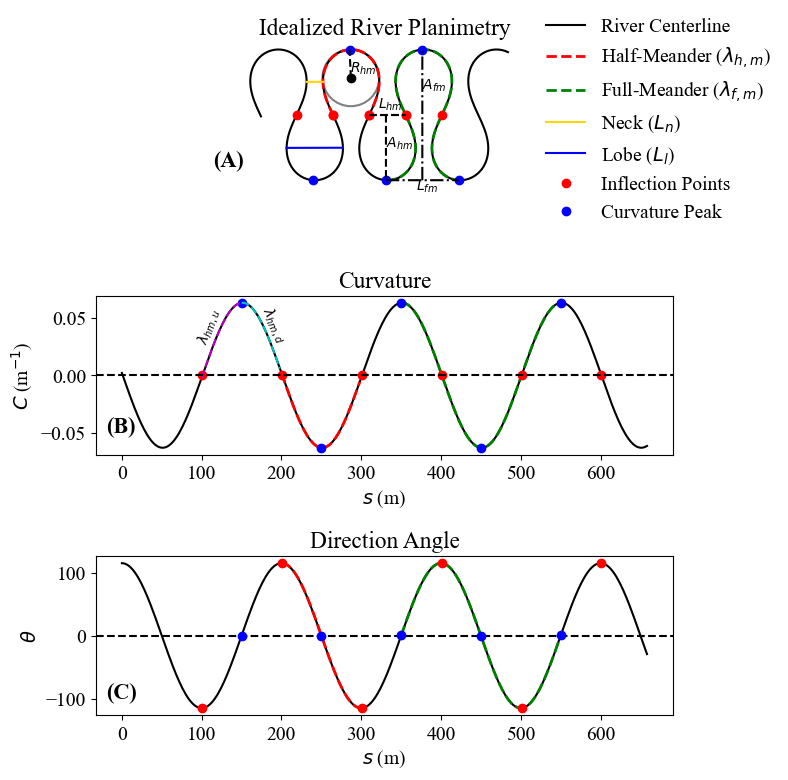

In [127]:
# ------------------------------ 
# Create Kinoshita Curve 
# ------------------------------
theta_0 = 115*np.pi/180  # radians
theta_0 = 115*np.pi/180  # radians
# Create 1 Full meanders (2 half-meanders)
# n = 32
n = 35
m_points = 3500
# m_points = 4000
# x_k, y_k, data = RF.kinoshita_curve_zolezzi(
#     theta_0=theta_0, lambda_value=200, theta_s=0.1, theta_f=0, n=n,
#     m_points=m_points)
x_k, y_k, data = RF.kinoshita_curve_zolezzi(
    theta_0=theta_0, lambda_value=200, theta_s=0.0, theta_f=0, n=n,
    m_points=m_points)

m_points = len(x_k)

# noise_value = 0.01
# x_k = x_k + np.random.normal(0, noise_value, size=x_k.shape)
# y_k = y_k + np.random.normal(0, noise_value, size=y_k.shape)
# ==============================
# WigglyRivers
# ==============================
id_river = 'Kinoshita Idealized'
rivers_k = RiverDatasets(logger=logger)
rivers_k.add_river(id_river, x_k, y_k, resample_flag=True,
                        # kwargs_resample={'smooth': 1e-2},
                        kwargs_resample={},
                        scale_by_width=False)

# ------------------------------
# Calculate Curvature
# ------------------------------
rivers_k[id_river].calculate_curvature()
rivers_k[id_river].get_cwt_curvature()
# ------------------------------
# Extract CWT Tree
# ------------------------------
rivers_k[id_river].extract_cwt_tree()
# -----------------------------
# Prune by peak power
# -----------------------------
rivers_k[id_river].prune_tree_by_peak_power()
# -----------------------------
# Prune by sinuosity
# -----------------------------
rivers_k[id_river].prune_tree_by_sinuosity(1.05)
# -----------------------------
# Add meander to database
# -----------------------------
rivers_k[id_river].add_meanders_from_tree_scales(
    overwrite=True, clip='no', bounds_array_str='extended')
# ---------------------------
# Calculate reach sinuosity
# ---------------------------
rivers_k[id_river].calculate_reach_metrics()

# ---------------------------
# Extract Meander Database
# ---------------------------
id_meander = 1
meander_database = rivers_k[id_river].database
r_hm = meander_database['R_hm'].iloc[id_meander]
x_center = rivers_k[id_river].meanders[id_meander].x_c
y_center = rivers_k[id_river].meanders[id_meander].y_c
x_me = rivers_k[id_river].meanders[id_meander].x
y_me = rivers_k[id_river].meanders[id_meander].y
# Get middle point
coordinates = np.vstack((x_me, y_me)).T
s_val = RF.get_reach_distances(coordinates)
s_mid = s_val[-1] / 2
arg_mid = np.argmin(np.abs(s_val - s_mid))
x_mid = x_me[arg_mid]
y_mid = y_me[arg_mid]

print('R_hm', meander_database['R_hm'].iloc[id_meander])
print('lambda', meander_database['lambda'].iloc[id_meander])
print('lambda_hm', meander_database['lambda_hm'].iloc[id_meander])
print('lambda_fm', meander_database['lambda_fm'].iloc[id_meander])

# ==============================
# Extract Info for plotting
# ==============================
w = np.ones_like(x_k)*2
# Extract variables 
# s = data['s']
# c = data['c']
# theta = data['theta']
s = rivers_k[id_river].s
c = rivers_k[id_river].c
theta = rivers_k[id_river].angle

# Cut to 3 meanders
x_k = rivers_k[id_river].x
y_k = rivers_k[id_river].y
ind_m = m_points//n
cut = 3*ind_m + 30
# cut = len(x_k)
x_k = x_k[:cut]
y_k = y_k[:cut]
s = s[:cut]
c = c[:cut]
theta = theta[:cut]
# Extract inflection points
s_inf, c_inf, ind_l, _ = RF.get_inflection_points(s, c)
x_inf = x_k[ind_l]
y_inf = y_k[ind_l]
theta_inf = theta[ind_l]
x_inf = meander_database['x_inf'].iloc[:4].values
x_inf = np.array([x_inf[i] for i in range(len(x_inf))])
y_inf = meander_database['y_inf'].iloc[:4].values
y_inf = np.array([y_inf[i] for i in range(len(y_inf))])

# ------------------------------
# Find Amplitude
# ------------------------------
id_meander = 2
x_me = rivers_k[id_river].meanders[id_meander].x
y_me = rivers_k[id_river].meanders[id_meander].y

# Half-Meander
ind_inf_st = rivers_k[id_river].meanders[id_meander].ind_inf_st
ind_inf_end = rivers_k[id_river].meanders[id_meander].ind_inf_end

x_inf_me = x_me[ind_inf_st: ind_inf_end + 1]
y_inf_me = y_me[ind_inf_st: ind_inf_end + 1]
coords = np.vstack((x_inf_me, y_inf_me)).T
rotated_points, angle_rot = RF.translate_rotate(
    coords, index_initial=0, index_final=-1)

y_rot = rotated_points[:, 1]
if y_rot[len(y_rot)//2] < 0:
    y_rot = -y_rot
    rot = -1
arg_max = np.argmax(y_rot)
# Find maximum point in the original coordinates
x_max = x_inf_me[arg_max]
y_max = y_inf_me[arg_max]
# Find middle point between starting and ending point of the inflection
x_st = x_inf_me[0]
y_st = y_inf_me[0]
x_end = x_inf_me[-1]
y_end = y_inf_me[-1]
# x_mid_inf = 0.5*(x_st + x_end)
# y_mid_inf = 0.5*(y_st + y_end)
# Interpolate to find the point perpendicular in y
x_per = rotated_points[arg_max, 0]
y_per = 0
# Rotate back
coords_per = np.array([x_per, y_per])
coords_per, _ = RF.rotate(coords_per, coords_per, coords_per, -angle_rot)
coords_per = coords_per + np.array([x_inf_me[0], y_inf_me[0]])
x_mid_inf = coords_per[0]
y_mid_inf = coords_per[1]

# Full-Meander
id_meander = 3
x_me = rivers_k[id_river].meanders[id_meander].x
y_me = rivers_k[id_river].meanders[id_meander].y
coords = np.vstack((x_me, y_me)).T
rotated_points, angle_rot = RF.translate_rotate(
    coords, index_initial=0, index_final=-1)

y_rot = rotated_points[:, 1]
if y_rot[len(y_rot)//2] < 0:
    y_rot = -y_rot
    rot = -1
# Find maximum point in the original coordinates
arg_max = np.argmax(y_rot)
x_f_max = x_me[arg_max]
y_f_max = y_me[arg_max]
# # Find middle point between starting and ending point of the inflection
x_f_st = x_me[0]
y_f_st = y_me[0]
x_f_end = x_me[-1]
y_f_end = y_me[-1]
x_per = rotated_points[arg_max, 0]
y_per = 0
# Rotate back
coords_per = np.array([x_per, y_per])
coords_per, _ = RF.rotate(coords_per, coords_per, coords_per, -angle_rot)
coords_per = coords_per + np.array([x_me[0], y_me[0]])
x_mid_f = coords_per[0]
y_mid_f = coords_per[1]
# ------------------------------
# Find Funneling Factor
# ------------------------------
id_meander = 0
x_me = rivers_k[id_river].meanders[id_meander].x
y_me = rivers_k[id_river].meanders[id_meander].y
s_me = rivers_k[id_river].meanders[id_meander].s
ind_inf_st = rivers_k[id_river].meanders[id_meander].ind_inf_st
ind_inf_end = rivers_k[id_river].meanders[id_meander].ind_inf_end
results = RF.calculate_funneling_factor(
                x_me, y_me, s_me, ind_inf_st, ind_inf_end)
s_n = results['s_n']
s_l = results['s_l']

# Find closest points to s_l and s_n
arg_s_n_st = np.argmin(np.abs(s_me - s_n[0]))
arg_s_n_end = np.argmin(np.abs(s_me - s_n[1]))
x_neck = np.array([x_me[arg_s_n_st], x_me[arg_s_n_end]])
y_neck = np.array([y_me[arg_s_n_st], y_me[arg_s_n_end]])
arg_s_l_st = np.argmin(np.abs(s_me - s_l[0]))
arg_s_l_end = np.argmin(np.abs(s_me - s_l[1]))
x_lobe = np.array([x_me[arg_s_l_st], x_me[arg_s_l_end]])
y_lobe = np.array([y_me[arg_s_l_st], y_me[arg_s_l_end]])

# ------------------------------
# Pick a half meander
# ------------------------------
x_m = x_k[ind_l[2]: ind_l[3]]
y_m = y_k[ind_l[2]: ind_l[3]]
s_m = s[ind_l[2]: ind_l[3]]
c_m = c[ind_l[2]: ind_l[3]]

# ------------------------------
# Calculate Extremes in curvature
# ------------------------------
# Find maxima in curvature
argmax, _ = find_peaks(c, height=0)
# argmax = np.argmax(c)
x_c_1 = x_k[argmax]
y_c_1 = y_k[argmax]
c_c_1 = c[argmax]
s_c_1 = s[argmax]
theta_c_1 = theta[argmax]
argmin, _ = find_peaks(-c, height=0)
# argmin = np.argmin(c)
x_c_2 = x_k[argmin]
y_c_2 = y_k[argmin]
c_c_2 = c[argmin]
s_c_2 = s[argmin]
theta_c_2 = theta[argmin]

s_c_max = meander_database['s_c_max'].values[:5]
c_max = meander_database['c_max'].values[:5]
x_c_max = meander_database['x_c_max'].values[:5]
y_c_max = meander_database['y_c_max'].values[:5]
argmin = np.array([np.argmin(np.abs(s - s_c_max[i])) for i in range(len(s_c_max))])
theta_c_max = theta[argmin]
# ------------------------------
# Asymmetry
# ------------------------------
s_hu = s[ind_l[1]: argmax[0]]
c_hu = c[ind_l[1]: argmax[0]]
s_hd = s[argmax[0]: ind_l[2]]
c_hd = c[argmax[0]: ind_l[2]]
# ------------------------------
# Extract Full Meander
# ------------------------------
id_meander = 3
x_m_full = rivers_k[id_river].meanders[id_meander].x
y_m_full = rivers_k[id_river].meanders[id_meander].y
s_m_full = rivers_k[id_river].meanders[id_meander].s
c_m_full = rivers_k[id_river].meanders[id_meander].c
ind_start = rivers_k[id_river].meanders[id_meander].ind_start
ind_end = rivers_k[id_river].meanders[id_meander].ind_end
theta_m_full = theta[ind_start: ind_end + 1]
# find points where c == 0
arg_c_0 = np.argwhere(c_m_full == 0).reshape(-1)
indices = np.arange(len(s_m_full))
# remove the arg_c_0 from the indices
indices = indices[indices != arg_c_0[0]]
indices = indices[indices != arg_c_0[1]]
s_m_theta_full = s_m_full[indices]

# ------------------------------
# Plot
# ------------------------------
# ---------------------------
# Plot Scale tree
# ---------------------------
fs = 12
mpl.rcParams['font.size'] = fs
mpl.rcParams['font.family'] = 'Times New Roman'
rivers_k[id_river].plot_tree_nodes(markersize=1, linewidth=0.5)
plt.show()
# ---------------------------
# Plot Idelized planimetry
# ---------------------------
fs = 14
mpl.rcParams['font.size'] = fs
mpl.rcParams['font.family'] = 'Times New Roman'
# Plot Kinoshita Curve
plt.close('all')
fig, axs = plt.subplots(3, 1, figsize=(8, 8))
axs[0].set_title('Idealized River Planimetry')
axs[0].plot(x_k, y_k, '-k', label='River Centerline')
axs[0].plot(x_m, y_m, '--r', label=f'Half-Meander ($\lambda_{{h,m}}$)', lw=2)
axs[0].plot(x_m_full, y_m_full, '--g', lw=2, label=f'Full-Meander ($\lambda_{{f,m}}$)')
# Funneling factor distances
axs[0].plot(x_neck, y_neck, '-', color='gold', label=f'Neck ($L_{{n}}$)')
axs[0].plot(x_lobe, y_lobe, '-b', label=f'Lobe ($L_{{l}}$)')
# Points
axs[0].plot(x_inf[:, 0], y_inf[:, 0], 'or', label='Inflection Points')
axs[0].plot(x_inf[:, 1], y_inf[:, 1], 'or')
axs[0].plot(x_c_max, y_c_max, 'ob', label='Curvature Peak')
# L_hm
axs[0].plot(x_inf[2], y_inf[2], '--k')
x_r_text = x_inf[2,0] + 0.5*(x_inf[2,1] - x_inf[2,0])
y_r_text = y_inf[2,0] + 0.2*(y_inf[2,1] - y_inf[2,0])
axs[0].text(x_r_text-6, y_r_text+4, r'$L_{hm}$', fontsize=fs - 4)
# L_fm
axs[0].plot([x_f_st, x_f_end], [y_f_st, y_f_end], '-.k')
x_r_text = x_f_st + 0.5*(x_f_end - x_f_st)
y_r_text = y_f_st + 0.5*(y_f_end - y_f_st)
axs[0].text(x_r_text-4, y_r_text-6, r'$L_{fm}$', fontsize=fs - 4)
# axs[0].plot(x_c_1, y_c_1, 'ob', label='Curvature Peak')
# axs[0].plot(x_c_2, y_c_2, 'ob')
# Plot Radius of Curvature
axs[0].plot(x_center, y_center, 'ok')
axs[0].plot([x_center, x_mid], [y_center, y_mid], '--k')
# Find center in line
x_r_text = x_center + 0.5*(x_mid - x_center)
y_r_text = y_center + 0.2*(y_mid - y_center)
axs[0].text(x_r_text, y_r_text, r'$R_{hm}$', fontsize=fs - 4)
circle = plt.Circle((x_center, y_center), r_hm, color='gray',
                    fill=False, lw=1.5)
axs[0].add_artist(circle)
# Plot line for amplitude
axs[0].plot([x_st, x_end], [y_st, y_end], '--k')
axs[0].plot([x_mid_inf, x_max], [y_mid_inf, y_max], '--k')
x_r_text = x_max + 0.5*(x_mid_inf - x_max)
y_r_text = y_max + 0.5*(y_mid_inf - y_max)
axs[0].text(x_r_text, y_r_text, r'$A_{hm}$', fontsize=fs - 4)
# axs[0].plot(x_max, y_max, 'ok')
# axs[0].plot(x_mid_inf, y_mid_inf, 'ok')
axs[0].plot([x_mid_f, x_f_max], [y_mid_f, y_f_max], '-.k')
x_r_text = x_f_max + 0.5*(x_mid_f - x_f_max)
y_r_text = y_f_max + 0.3*(y_mid_f - y_f_max)
axs[0].text(x_r_text, y_r_text, r'$A_{fm}$', fontsize=fs - 4)
# Finish Axes
axs[0].set_xlim(-100, x_k[-1]+100)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_aspect('equal', adjustable='box')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)
axs[0].spines['left'].set_visible(False)
# legend to the left outside
# axs[0].legend(loc=2, bbox_to_anchor=(-0.15, 1.3), frameon=False)
axs[0].legend(loc=2, bbox_to_anchor=(0.75, 1.3), frameon=False)
# Literal
# fig.text(0.25, 0.95, r'(a)', ha='center', fontsize=fs+2, weight='bold')
fig.text(0.3, 0.78, r'(A)', ha='center', fontsize=fs+2, weight='bold')

# Include Equations
# fig.text(0.8, 0.8, r'$\sigma_{hm}=\lambda_{hm}/L_{hm}$', fontsize=fs - 4)

# Plot curvature
axs[1].set_title('Curvature')
axs[1].plot(s, c, '-k')
axs[1].plot(s_m, c_m, '--r', lw=2)
axs[1].plot(s_m_full, c_m_full, '--g', lw=2)
axs[1].plot(s_inf[1:], c_inf[1:], 'or')
axs[1].plot(s_c_max, c_max, 'ob')
# Plot line from inflection to max curvature
axs[1].plot(s_hu, c_hu, '--', color='m')
axs[1].plot(s_hd, c_hd, '--', color='c')
axs[1].text(90, 0.03, r'$\lambda_{hm,u}$', fontsize=fs-4, rotation=70)
axs[1].text(170, 0.03, r'$\lambda_{hm,d}$', fontsize=fs-4, rotation=-65)
# axs[1].plot(s_c_1, c_c_1, 'ob')
# axs[1].plot(s_c_2, c_c_2, 'ob')
axs[1].axhline(0, color='k', linestyle='--')
axs[1].set_xlabel(r'$s$ (m)')
axs[1].set_ylabel(r'$C$ (m$^{-1}$)')
# Literal
axs[1].text(-20, -0.05, r'(B)', fontsize=fs+2, weight='bold')

# Plot Angle
axs[2].set_title('Direction Angle')
axs[2].plot(s, theta, '-k')
axs[2].axhline(0, color='k', linestyle='--')
axs[2].plot(s_m, theta[ind_l[0]: ind_l[1]], '--r', lw=2)
axs[2].plot(s_m_theta_full, theta_m_full, '--g', lw=2)
axs[2].plot(s_inf[1:], theta_inf[1:], 'or')
axs[2].plot(s_c_max, theta_c_max, 'ob')
# axs[2].plot(s_c_1, theta_c_1, 'ob')
# axs[2].plot(s_c_2, theta_c_2, 'ob')
axs[2].set_xlabel(r'$s$ (m)')
axs[2].set_ylabel(r'$\theta$')
axs[2].text(-20, -100, r'(C)', fontsize=fs+2, weight='bold')
plt.tight_layout()
utl.cr_folder('../manuscript_figures/')
plt.savefig('../manuscript_figures/Figure_02_Conceptual_meander.png',
            dpi=500)
plt.show()



### Example on Noisy River Planimetry

The numerical computation of the curvature and the direction angle depend on first- and second-order derviatives of the river planimetry. Thus, noise in the measurements of the river centerline can lead to large errors in the calculation of these river variables. The following code block shows this effect by adding noise to a Kinoshita curve.

/Users/dgd042/Documents/work/myRepos/inDevelopment/WigglyRivers/WigglyRivers/rivers/RiverFunctions.py:824: RuntimeWarning: All-NaN slice encountered
  w_value = np.nanmin(w)


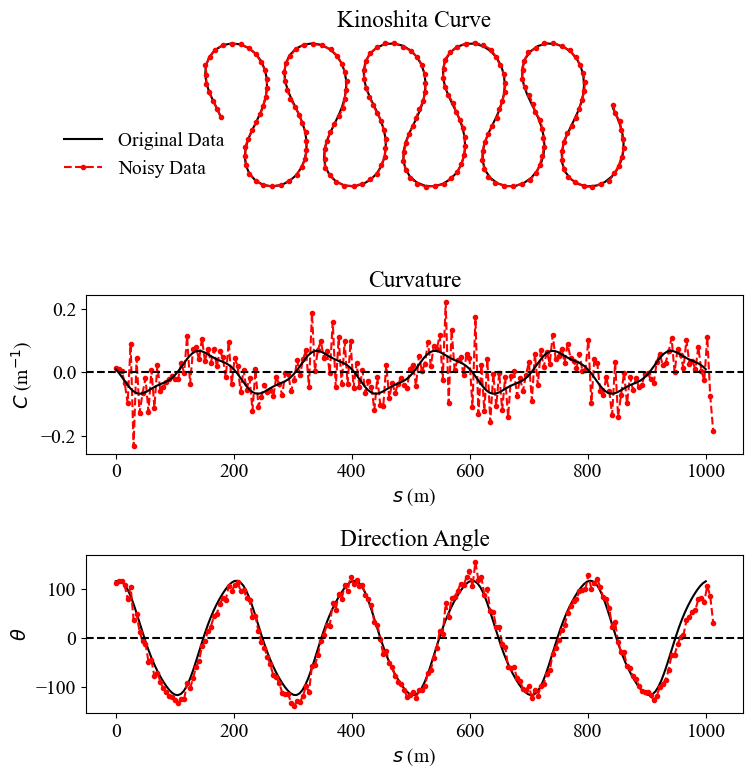

In [44]:
# Create Kinoshigta River
theta_0 = 115*np.pi/180  # radians
n = 5
x_k, y_k, data = RF.kinoshita_curve_zolezzi(
    theta_0=theta_0, lambda_value=200, theta_s=0.1, theta_f=0, n=n,
    m_points=200)
w = np.ones_like(x_k)*1
# Extract variables 
s = data['s']
c = data['c']
theta = data['theta']

# ----------------------
# Add noise in the data
# ----------------------
noise_value = 0.3
x_noise = x_k + np.random.normal(0, noise_value, size=x_k.shape)
y_noise = y_k + np.random.normal(0, noise_value, size=y_k.shape)

rivers = RiverDatasets()
rivers.add_river('0', x=x_noise, y=y_noise)
rivers['0'].calculate_curvature()
x_noise = rivers['0'].x
y_noise = rivers['0'].y
c_noise = rivers['0'].c
s_noise = rivers['0'].s
theta_noise = rivers['0'].angle

# -----------------
# Plot
# -----------------
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

axs[0].set_title('Kinoshita Curve')
axs[0].plot(x_k, y_k, '-k', label='Original Data')
axs[0].plot(x_noise, y_noise, '.--r', label='Noisy Data')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_aspect('equal', adjustable='box')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)
axs[0].spines['left'].set_visible(False)
# legend to the left outside
axs[0].legend(loc=2, bbox_to_anchor=(-0.30, 0.5), frameon=False)

axs[1].set_title('Curvature')
axs[1].plot(s_noise, c_noise, '.--r')
axs[1].plot(s, c, 'k')
axs[1].axhline(0, color='k', linestyle='--')
axs[1].set_xlabel(r'$s$ (m)')
axs[1].set_ylabel(r'$C$ (m$^{-1}$)')

# Plot Angle
axs[2].set_title('Direction Angle')
axs[2].plot(s, theta, '-k')
axs[2].plot(s_noise, theta_noise, '.--r')
axs[2].axhline(0, color='k', linestyle='--')
axs[2].set_xlabel(r'$s$ (m)')
axs[2].set_ylabel(r'$\theta$')
plt.tight_layout()

utl.cr_folder('../manuscript_figures/')
plt.savefig('../manuscript_figures/Figure_S1_curvature_noise.png', dpi=500)
plt.show()


### River Transect Multiscale Characterization

In the following code blocks, we will be using the spectral tools within _WigglyRivers_ to explore the multiscale nature of ideal river transects created with the Kinoshita curves. We approach this characterization in two parts. First, we explored three Kinoshita-type river transects with 40 meander bends that have the same wavelength ($\lambda=100$ m), skewness ($\theta_s=0.344$), and fatness ($\theta_f=0.031$) but vary in the amplitude of the direction angle oscillation as $\theta_0=[37.24, 60, 120]$. 


In [128]:
# -----------------------------------------------
# Functions for Kinoshita Curve exploration
# -----------------------------------------------
def explore_kinoshita_values(theta_0, lambda_value, theta_s, theta_f, n,
                             plot_flag=False):
    x_k, y_k, data = RF.kinoshita_curve_zolezzi(
        theta_0=theta_0, lambda_value=lambda_value, theta_s=theta_s,
        theta_f=theta_f, n=n)
    w_m = np.ones_like(x_k)
    # Create River Object
    rivers_k = RiverDatasets(logger=logger)
    rivers_k.add_river('0', x_k, y_k, w_m=w_m, resample_flag=True,
                       kwargs_resample={}, scale_by_width=False)
    # Calculate curvature
    rivers_k['0'].calculate_curvature()
    # Calculate CWT
    rivers_k['0'].get_cwt_curvature(mother='MORLET')
    rivers_k['0'].get_cwt_angle(mother='MORLET')
    results = {
        'rivers': rivers_k,
    }
    return results


2024-02-05 21:55:21,968[INFO] info: Start Logger in RiverDatasets
2024-02-05 21:55:22,054[INFO] info: Start Logger in RiverDatasets


2024-02-05 21:55:22,130[INFO] info: Start Logger in RiverDatasets


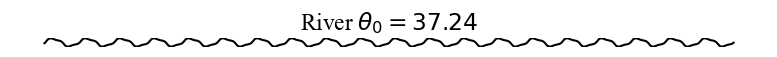

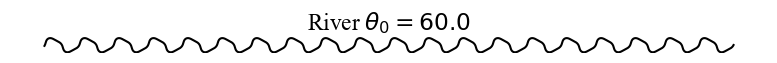

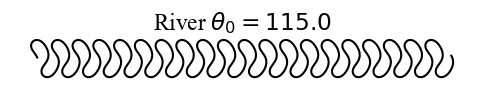

In [129]:
# -----------------------------------------------
# Creation of the Kinoshita-type River transects
# -----------------------------------------------
theta_0 = np.array([37.24, 60, 115])  # Degrees
theta_s = np.array([0.344, 0.344, 0.344])
theta_f = 0.031
lambda_value = 100
n = 20
variables = ['rivers']
results_theta = {i: [] for i in variables}
# Explore values
for i in range(len(theta_0)):
    result = explore_kinoshita_values(
        theta_0[i]*np.pi/180, lambda_value, theta_s[i], theta_f, n)
    for var in variables:
        results_theta[var].append(result[var])

# --------------
# Plot Rivers
# --------------
utl.cr_folder('kinoshita_results/')
river_ids = np.arange(len(theta_0))
for river_id in river_ids:
    x_ch = results_theta['rivers'][river_id]['0'].x
    y_ch = results_theta['rivers'][river_id]['0'].y
    plt.figure(figsize=(8, 1))
    plt.plot(x_ch, y_ch, '-k')
    # plt.plot(x_ch, y_ch, 'ob')
    plt.title(f'River $\\theta_0={theta_0[river_id]}$')
    plt.gca().set_aspect('equal', adjustable='box')
    # Remove ticks
    plt.xticks([])
    plt.yticks([])
    # Remove axis lines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.tight_layout()
    plt.savefig(f'kinoshita_results/river_{river_id}.png', dpi=300)


#### Spectral Analysis

Within the function `explore_kinoshita_values()` we calculate the curvature ($C$) and the direction angle ($\theta$) and apply a Continous Wavelet Transform (CWT) to these variables to gain insight into the spectral properties of these river transects. Finally, we calculate the global wavelet spectrum (GWS) and the scale-averaged wavelet power (SAWP) over the significant scales of the CWT. On this first analysis we are interested in looking into the periodicity of the meander bends, thus we decided to use the Morlet mother wavelet, similarly to what was done by Zolezzi and Güneralp (2016).

The following code blocks below will create the compiled figures of all the river transects with 95% significance.

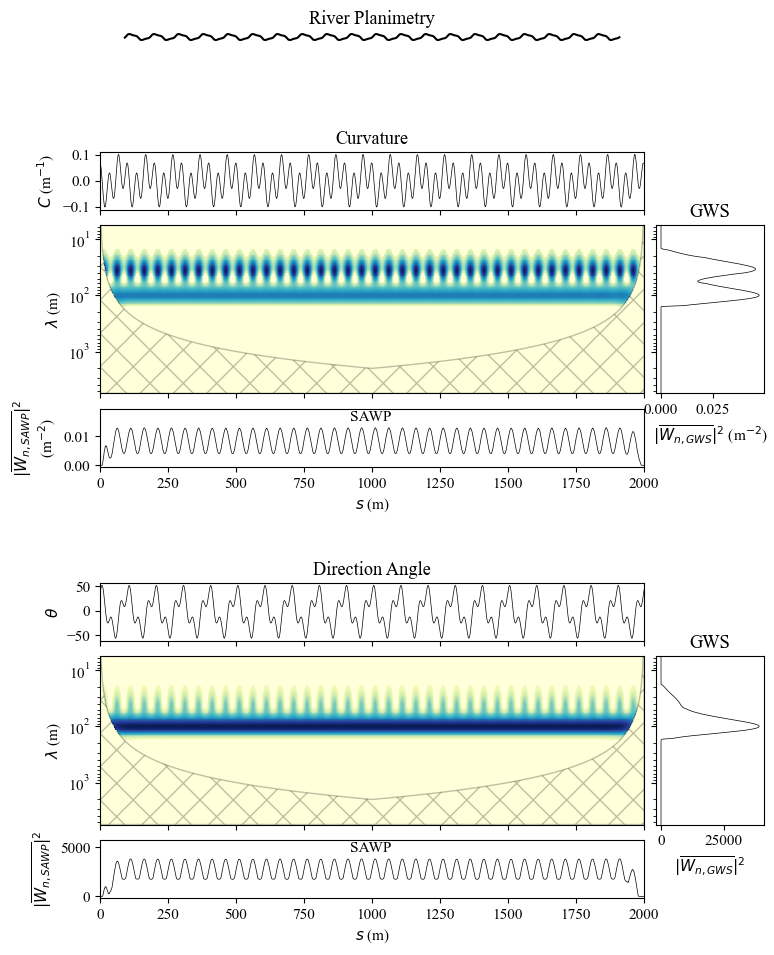

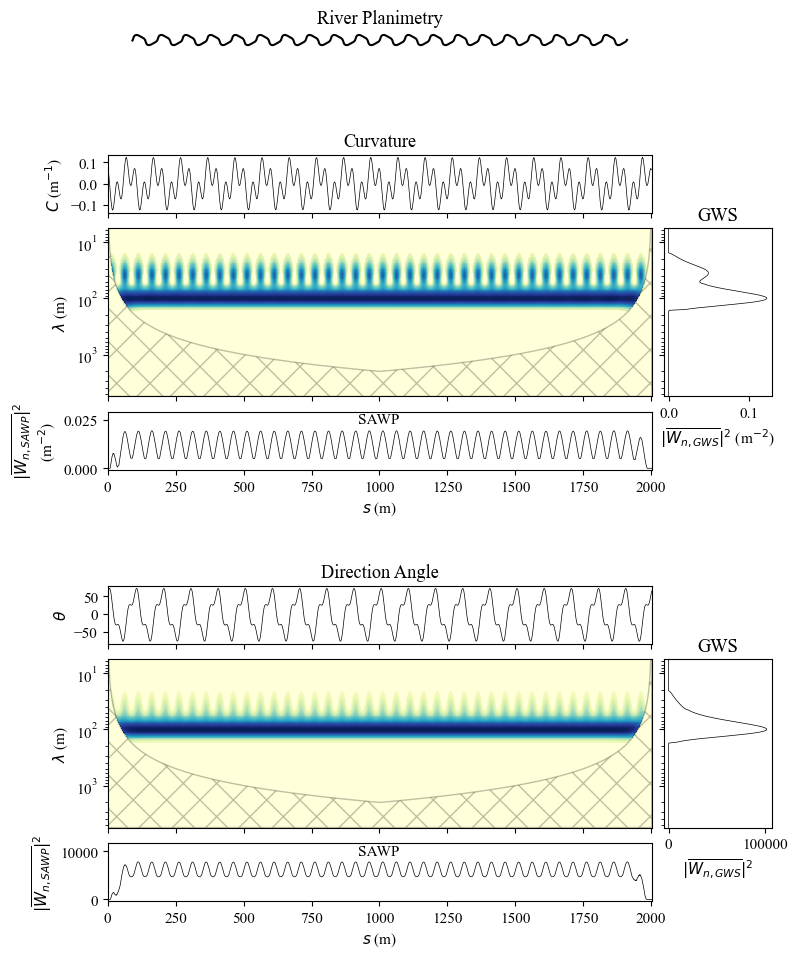

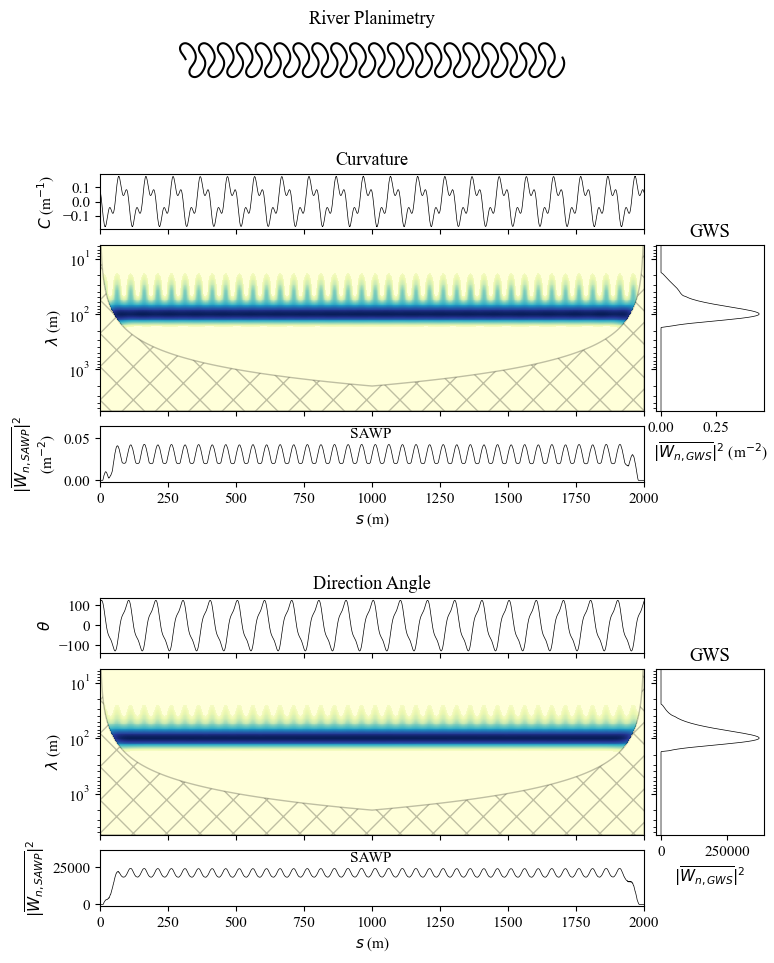

In [130]:
# Plot Condense analysis only presenting values for the 95% significance 
fs = 11
mpl.rcParams['font.size'] = fs
mpl.rcParams['font.family'] = 'Times New Roman'
plt.close('all')
for i in range(len(theta_0)):
    river = results_theta['rivers'][i]['0']
    graphs.plot_river_spectrum_compiled(river, only_significant=True)
    utl.cr_folder('kinoshita_results/')
    plt.savefig(f'kinoshita_results/kinoshita_river_{i}_sig95.png', dpi=500)


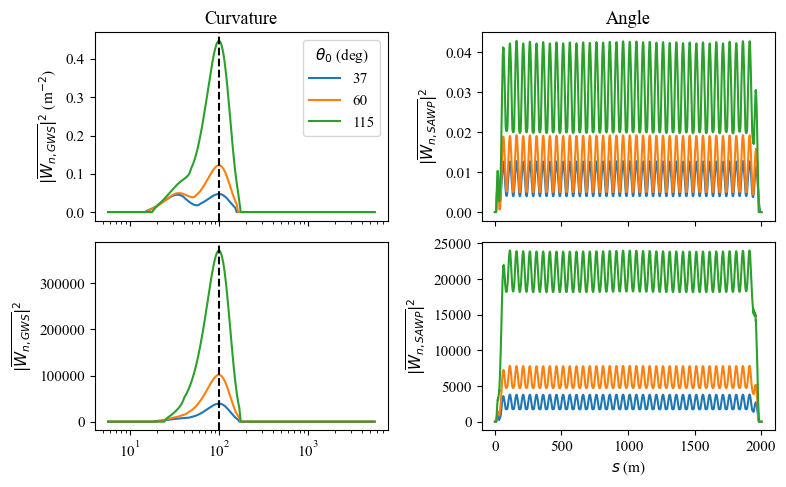

In [146]:
# --------------------
# Plot GWS information
# --------------------
plt.close('all')
f, ax = plt.subplots(2, 2, figsize=(8, 5), sharex='col')
ax = ax.ravel()
i_dat = 0
ax[i_dat].set_title('Curvature')
for i in range(len(theta_0)):
    ax[i_dat].plot(results_theta['rivers'][i]['0'].cwt_wavelength_c,
                   results_theta['rivers'][i]['0'].cwt_gws_c_sig,
                   label=f'{theta_0[i]:.0f}')
# ax[i_dat].set_xlabel(f'$\lambda$ (m)')
ax[i_dat].axvline(lambda_value, color='k', linestyle='--')
ax[i_dat].set_ylabel(r"$|\overline{W_{n,GWS}}|^2$ (m$^{-2}$)")
ax[i_dat].set_xscale('log')
ax[i_dat].legend(title='$\\theta_0$ (deg)')

i_dat = 2
# ax[i_dat].set_title('Angle')
for i in range(len(theta_0)):
    ax[i_dat].plot(results_theta['rivers'][i]['0'].cwt_wavelength_angle,
             results_theta['rivers'][i]['0'].cwt_gws_angle_sig,
             label=f'{theta_0[i]:.0f}')
# ax[i_dat].set_xlabel(r'$\lambda$ (m)')
ax[i_dat].set_ylabel(r"$|\overline{W_{n,GWS}}|^2$")
ax[i_dat].axvline(lambda_value, color='k', linestyle='--')
ax[i_dat].set_xscale('log')

i_dat = 1
ax[i_dat].set_title('Angle')
for i in range(len(theta_0)):
    ax[i_dat].plot(results_theta['rivers'][i]['0'].s,
                   results_theta['rivers'][i]['0'].cwt_sawp_c_sig,
                   label=f'{theta_0[i]:.0f}')
# ax[i_dat].set_xlabel('Wavelength (m)')
ax[i_dat].set_ylabel(r"$|\overline{W_{n,SAWP}}|^2$")
# ax[i_dat].axvline(lambda_value, color='k', linestyle='--')
# ax[i_dat].set_ylabel('Power$^2$')
# ax[i_dat].set_xscale('log')
# ax[i_dat].legend(title='$\\theta_0$ (deg)')

i_dat = 3
# ax[i_dat].set_title('Angle')
for i in range(len(theta_0)):
    ax[i_dat].plot(results_theta['rivers'][i]['0'].s,
             results_theta['rivers'][i]['0'].cwt_sawp_angle_sig,
             label=f'{theta_0[i]:.0f}')
ax[i_dat].set_ylabel(r"$|\overline{W_{n,SAWP}}|^2$")
ax[i_dat].set_xlabel('$s$ (m)')
# ax[i_dat].set_xlim([160, 160+50])


plt.tight_layout()
plt.savefig(f'kinoshita_results/compare_GWS_theta_angle.png', dpi=500)
plt.show()

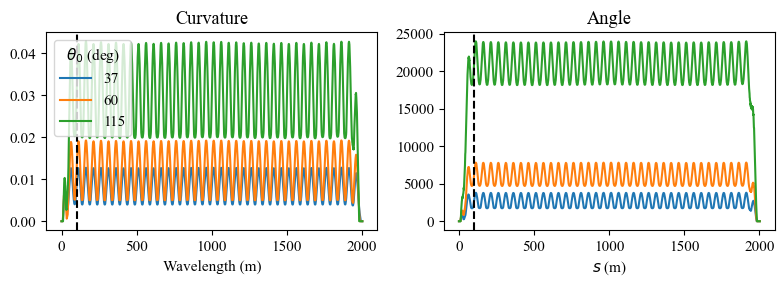

In [135]:
# --------------------
# Plot GWS information
# --------------------
plt.close('all')
f, ax = plt.subplots(1, 2, figsize=(8, 3))
i_dat = 0
ax[i_dat].set_title('Curvature')
for i in range(len(theta_0)):
    ax[i_dat].plot(results_theta['rivers'][i]['0'].s,
                   results_theta['rivers'][i]['0'].cwt_sawp_c_sig,
                   label=f'{theta_0[i]:.0f}')
ax[i_dat].set_xlabel('Wavelength (m)')
ax[i_dat].axvline(lambda_value, color='k', linestyle='--')
# ax[i_dat].set_ylabel('Power$^2$')
# ax[i_dat].set_xscale('log')
ax[i_dat].legend(title='$\\theta_0$ (deg)')

i_dat = 1
ax[i_dat].set_title('Angle')
for i in range(len(theta_0)):
    ax[i_dat].plot(results_theta['rivers'][i]['0'].s,
             results_theta['rivers'][i]['0'].cwt_sawp_angle_sig,
             label=f'{theta_0[i]:.0f}')
ax[i_dat].set_xlabel('$s$ (m)')
# ax[i_dat].ylabel('Power$^2$')
ax[i_dat].axvline(lambda_value, color='k', linestyle='--')
# ax[i_dat].set_xscale('log')
plt.tight_layout()
plt.savefig(f'kinoshita_results/compare_SAWP_theta_angle.png', dpi=500)
plt.show()


As expected, we see that although the meanders have a variety of shapes, the wavelengths are the same. 

TODO: Finish analysis

For the following example, we explore the effects of variations in the wavelength ($\lambda$) of the Kinoshita curve. We create a single meander reach where the wavelength is varying every 5 meander beds as follows $\lambda=[50, 100, 200, 500, 1000]$. The other parameters are kept constant as $\theta_0=110$, $\theta_s=0.344$, and $\theta_f=0.031$. The following code blocks below will create the compiled figures of all the river transects with and without 95% significance.

In [48]:
# Vary lambda
theta_0 = 110
# theta_s = 0.344
# theta_f = 0.031
theta_s = 0
theta_f = 0
lambda_value = [50, 100, 200, 500]
n = 5
# variables = ['rivers', 's', 'c', 'theta', 'cwt_morlet_angle',
#              'power_morlet_angle', 'wavelen_morlet_angle', 'gws_angle',
#              'sum_wave_angle', 'cwt_morlet_c', 'power_morlet_c',
#              'wavelen_morlet_c', 'gws_c', 'sum_wave_c']
variables = ['rivers']

results_lambda = {i: [] for i in variables}

for i in range(len(lambda_value)):
    result = explore_kinoshita_values(
        theta_0*np.pi/180, lambda_value[i], theta_s, theta_f, n)

    if i == 0:
        results_lambda['rivers'] = result['rivers']
    else:
        results_lambda['rivers']['0'].x = np.concatenate(
            (results_lambda['rivers']['0'].x[:-2], result['rivers']['0'].x + results_lambda['rivers']['0'].x[-1]))
        results_lambda['rivers']['0'].y = np.concatenate(
            (results_lambda['rivers']['0'].y[:-2], result['rivers']['0'].y))
        results_lambda['rivers']['0'].w_m = np.concatenate(
            (results_lambda['rivers']['0'].w_m, result['rivers']['0'].w_m))
        results_lambda['rivers']['0'].s = np.concatenate(
            (results_lambda['rivers']['0'].s, result['rivers']['0'].s + np.max(results_lambda['rivers']['0'].s)))

x = results_lambda['rivers']['0'].x
y = results_lambda['rivers']['0'].y
w_m = np.ones_like(x)

rivers_lambda = RiverDatasets(logger=logger)
rivers_lambda.add_river('0', x, y, w_m=w_m, resample_flag=True,
                        kwargs_resample={}, scale_by_width=False)

# Calculate curvature and angle
rivers_lambda['0'].calculate_curvature()
rivers_lambda['0'].get_cwt_curvature(mother='MORLET')
rivers_lambda['0'].get_cwt_angle(mother='MORLET')
x_ch = rivers_lambda['0'].x
y_ch = rivers_lambda['0'].y

2024-02-05 14:14:36,802[INFO] info: Start Logger in RiverDatasets
2024-02-05 14:14:36,813[INFO] info: Start Logger in RiverDatasets


2024-02-05 14:14:36,830[INFO] info: Start Logger in RiverDatasets
2024-02-05 14:14:36,861[INFO] info: Start Logger in RiverDatasets
2024-02-05 14:14:36,933[INFO] info: Start Logger in RiverDatasets


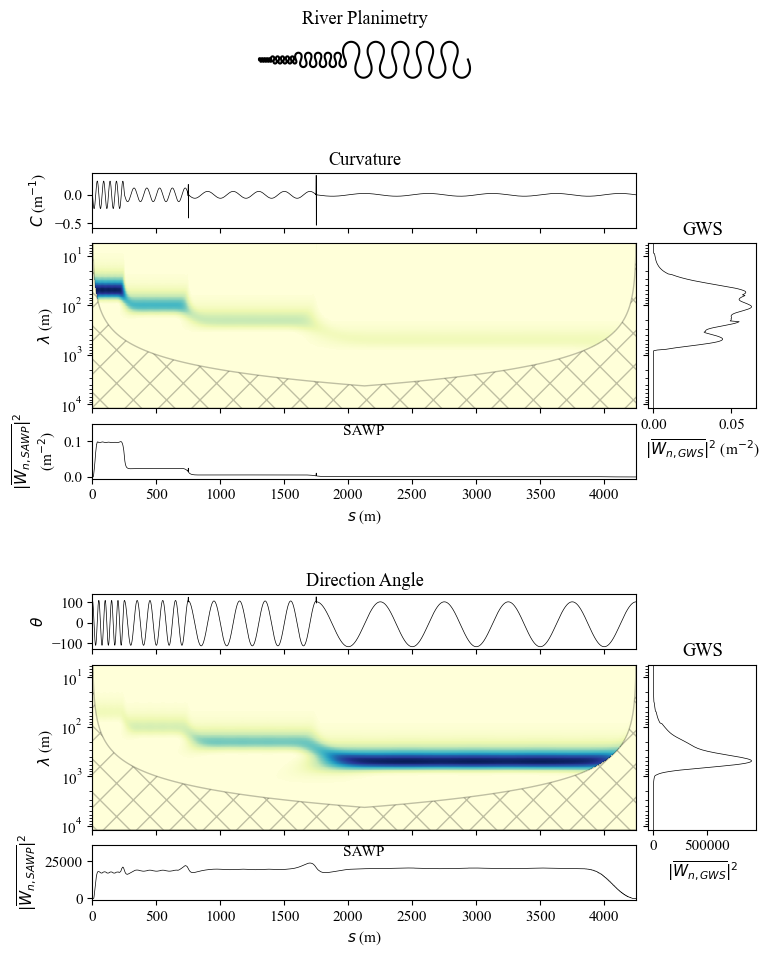

In [49]:
# Plot metrics with only significant values
river = rivers_lambda['0']
graphs.plot_river_spectrum_compiled(river, only_significant=True)
utl.cr_folder('kinoshita_results/')
plt.savefig('kinoshita_results/kinoshita_lambda_sig.png', dpi=500)
plt.savefig('kinoshita_results/kinoshita_lambda_sig.pdf', dpi=500)


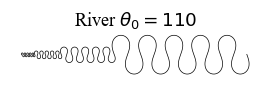

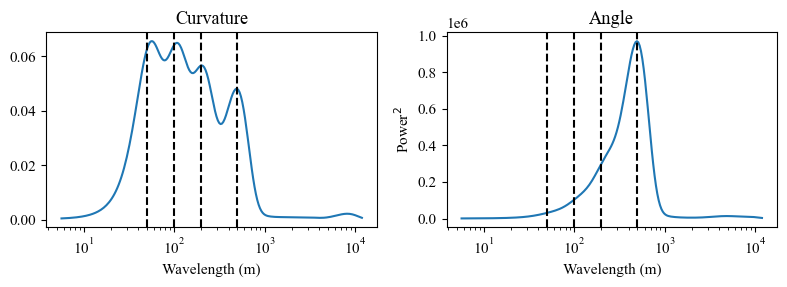

In [23]:
plt.figure(figsize=(8, 1))
plt.plot(x_ch, y_ch, '-k', linewidth=0.5)
plt.title(f'River $\\theta_0=110$')
plt.gca().set_aspect('equal', adjustable='box')
# Remove ticks
plt.xticks([])
plt.yticks([])
# Remove axis lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tight_layout()
plt.savefig(f'kinoshita_results/river_lambda.png', dpi=300)
plt.show()

# Plot GWS information
f, ax = plt.subplots(1, 2, figsize=(8, 3))
# Curavture
ax[0].set_title('Curvature')
ax[0].plot(rivers_lambda['0'].cwt_wavelength_c,
               rivers_lambda['0'].cwt_gws_c)
ax[0].set_xlabel('Wavelength (m)')
for lambda_v in lambda_value:
    ax[0].axvline(lambda_v, color='k', linestyle='--')
ax[0].set_xscale('log')
# Angle
ax[1].set_title('Angle')
ax[1].plot(rivers_lambda['0'].cwt_wavelength_angle,
           rivers_lambda['0'].cwt_gws_angle)
ax[1].set_xlabel('Wavelength (m)')
ax[1].set_ylabel('Power$^2$')
for lambda_v in lambda_value:
    ax[1].axvline(lambda_v, color='k', linestyle='--')
ax[1].set_xscale('log')
plt.tight_layout()
plt.savefig(f'kinoshita_results/compare_GWS_lambda.png', dpi=500)
plt.show()


### Meander Characterization Tool

In the following code blocks we will show how to use the 

In [24]:
# =================================
# Create River
# =================================
# theta_0 = np.array([37.24, 60, 115])  # Degrees
# theta_s = np.array([0.344, 0.344, 0.344])
theta_0 = 115  # Degrees
theta_s = 0.344
theta_f = 0.031
lambda_value = 100
n = 20
x_k, y_k, data = RF.kinoshita_curve_zolezzi(
    theta_0=theta_0*np.pi/180, lambda_value=lambda_value, theta_s=theta_s,
    theta_f=theta_f, n=n)
w_m = np.ones_like(x_k)
# Create River Object
rivers = RiverDatasets(logger=logger)
rivers.add_river('0', x_k, y_k, w_m=w_m, resample_flag=True,
                    kwargs_resample={}, scale_by_width=False)

# Calculate curvature
rivers['0'].calculate_curvature()
# =================================
# Extract Meanders
# =================================
# --------------------
# Calculate CWT
# --------------------
rivers[f'0'].extract_cwt_tree()
# -----------------------------
# Prune by peak power
# -----------------------------
rivers[f'0'].prune_tree_by_peak_power()
# -----------------------------
# Prune by sinuosity
# -----------------------------
rivers[f'0'].prune_tree_by_sinuosity(1.05)
# -----------------------------
# Add meander to database
# -----------------------------
rivers[f'0'].add_meanders_from_tree_scales(overwrite=True, clip='downstream')
# ---------------------------
# Calculate reach sinuosity
# ---------------------------
rivers[f'0'].calculate_reach_metrics()

2024-02-05 08:03:47,171[INFO] info: Start Logger in RiverDatasets
2024-02-05 08:03:47,177[INFO] info:   Running CWT...


2024-02-05 08:03:47,215[INFO] info:   Getting the scale tree...
2024-02-05 08:03:47,882[INFO] info:   Finding peaks in CWT...
2024-02-05 08:03:47,925[INFO] info:   Detecting meanders...
2024-02-05 08:03:47,931[INFO] info:   Projecting tree in planimetry...


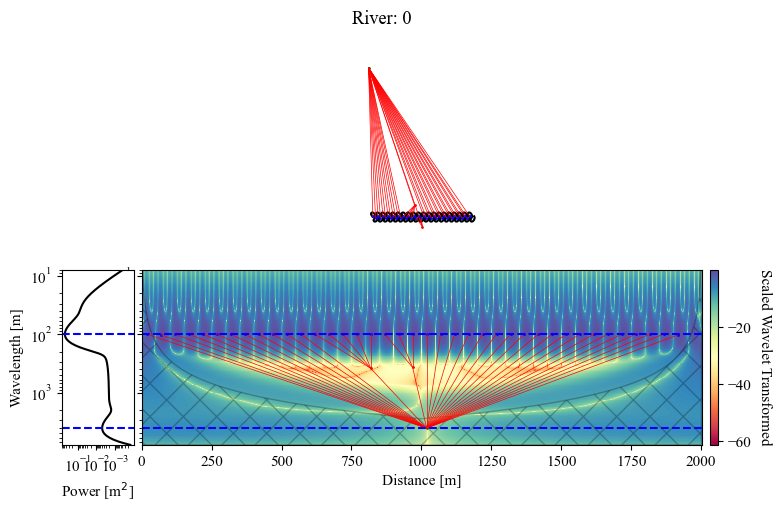

In [25]:
# Look at the meanders
rivers['0'].plot_tree_nodes(markersize=1, linewidth=0.5)

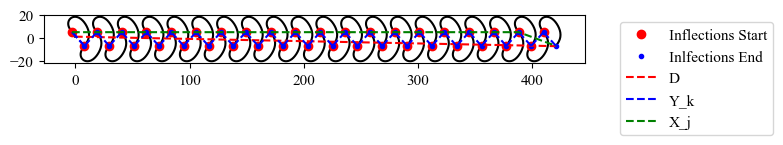

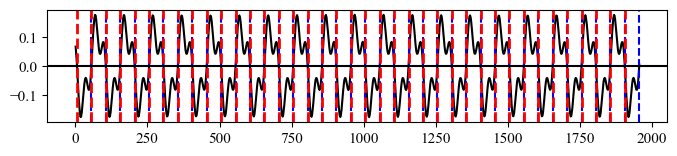

In [26]:
# Plot tree with inflection points
river_id = '0'
tree_id = 0
x_all = rivers[river_id].x
y_all = rivers[river_id].y
x = rivers[river_id].x
y = rivers[river_id].y
c = rivers[river_id].c
s_all = rivers[river_id].s
root_node = rivers[river_id].tree_scales[tree_id]
idx_st = root_node.idx_leaf_start
idx_end = root_node.idx_leaf_end
x = x[idx_st:idx_end]
y = y[idx_st:idx_end]
c = c[idx_st:idx_end]
s = s_all[idx_st:idx_end]
# database = rivers[river_id].tree_scales_database_meanders
# subdatabase = database[database['tree_id'] == tree_id]
# idx_inf_start = subdatabase['idx_planimetry_start'].values
# idx_inf_end = subdatabase['idx_planimetry_end'].values
database = rivers[river_id].database
subdatabase = database[database['tree_id'] == tree_id]
x_inf_start = subdatabase['x_start'].values
x_inf_end = subdatabase['x_end'].values
y_inf_start = subdatabase['y_start'].values
y_inf_end = subdatabase['y_end'].values
s_inf_start = subdatabase['s_start'].values
s_inf_end = subdatabase['s_end'].values

# Get lines for metrics
# Starting and ending point
d = np.array([[x[0], y[0]], [x[-1], y[-1]]])
# Hal-meander distance Y_k
# y_k = np.array([[x_all[idx_inf_start], y_all[idx_inf_start]],
#                 [x_all[idx_inf_end], y_all[idx_inf_end]]])
y_k = np.array([[x_inf_start, y_inf_start],
                [x_inf_end, y_inf_end]])
# Full meander distance X_j
n = subdatabase.shape[0]
i_start = np.arange(0, n - 1, 2)

subset_database = rivers[river_id].database[rivers[river_id].database['tree_id'] == tree_id]
x_f_m = subset_database['x_start'].values[i_start]
y_f_m = subset_database['y_start'].values[i_start]
x_f_m = np.hstack((x_f_m, subset_database['x_end'].values[-1]))
y_f_m = np.hstack((y_f_m, subset_database['y_end'].values[-1]))
x_j = np.array([x_f_m, y_f_m]).T


utl.cr_folder('kinoshita_results/closer_look/')
# plot
plt.close('all')
plt.figure(figsize=(8, 5))
plt.plot(x, y, '-k')
# plot inflection points
plt.plot(x_inf_start, y_inf_start, 'or', label='Inflections Start')
plt.plot(x_inf_end, y_inf_end, '.b', label='Inlfections End')
# plot D
plt.plot(d[:, 0], d[:, 1], '--r', label='D')
# plot y_k
plt.plot([y_k[0, 0, 0], y_k[1, 0, 0]], [y_k[0, 1, 0], y_k[1, 1, 0]], '--b', label='Y_k')
plt.plot(y_k[:, 0], y_k[:, 1], '--b')
# plot x_j
plt.plot(x_j[:, 0], x_j[:, 1], '--g', label='$X_j$')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(
    f'kinoshita_results/closer_look/river_{river_id}_tree_{tree_id}_inflections.png',
    dpi=300)

plt.show()

# plot curvature
plt.figure(figsize=(8, 5))
plt.plot(s, c, '-k')
# plot inflection points
for i in range(len(s_inf_start)):
    plt.axvline(s_inf_start[i], color='r', linestyle='--', label='Inflections Start',
                linewidth=2)
    plt.axvline(s_inf_end[i], color='b', linestyle='--', label='Inflections End')
plt.axhline(0, color='k', linestyle='-')
plt.gca().set_aspect(1000, adjustable='box')
plt.savefig(
    f'kinoshita_results/closer_look/c_{river_id}_tree_{tree_id}_inflections.png',
    dpi=300)
plt.show()


# References

Zolezzi, G., & Güneralp, I. (2016). Continuous wavelet characterization of the wavelengths and regularity of meandering rivers. Geomorphology, 252, 98–111. https://doi.org/10.1016/j.geomorph.2015.07.029
